This notebook was used to derive the functional form of our S-Curve, and make a plot of it.

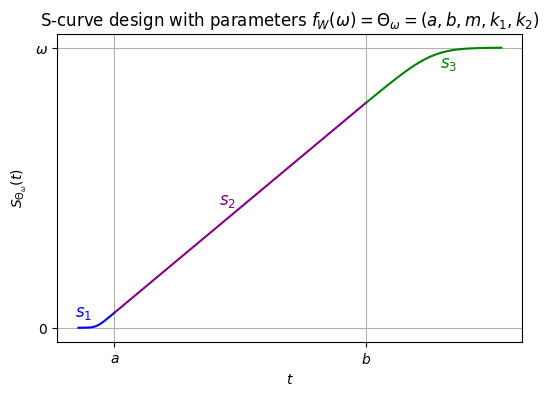

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def softplus_derivative(x, k):
    return 1 / (1 + np.exp(-x * k))

def softplus(x, sharpness):
    return np.log(1 + np.exp(sharpness * x))/sharpness

def inv_softplus(y, sharpness):
    return np.log(np.exp(sharpness * y) - 1) / sharpness


# softplus(x) is approx 0 for x <= 4
# softplus(x) is approx x for x >= 4
softplus_lin_point = 5
def softplus_startpart(x, a, target_slope, sharpness1):
    # We want that softplus(start) = 0 and softplus(a) = target_slope * x
    return softplus((x*2*softplus_lin_point/a - softplus_lin_point), sharpness = sharpness1) * target_slope / (2*softplus_lin_point) * a

def softplus_unshifted_endpart(x, b, target_slope, sharpness):
    return - softplus_startpart(-x, b, target_slope, sharpness)

def softplus_endpart(x, limit, a, b, target_slope, sharpness1, sharpness2):
    # Calculate x for which linear part would be 0

    eps = 1e-8
    slope = (softplus_startpart(b, a, target_slope, sharpness1) - softplus_startpart(b-eps, a, target_slope, sharpness1))/(eps)
    # softplus_startpart(b, a, target_slope, sharpness) - (b-x) * slope = 0
    x_lin = - softplus_startpart(b, a, target_slope, sharpness1) / slope + b

    # Calculate x for which endpart would be 0
    # limit + softplus_unshifted_endpart(x, b, target_slope, sharpness) = 0
    # softplus_unshifted_endpart(x, b, target_slope, sharpness) = -limit
    # softplus_startpart(-x, b, target_slope, sharpness) = limit
    # softplus((-x*(2*softplus_lin_point)/b - softplus_lin_point), sharpness = sharpness) * target_slope / (2*softplus_lin_point) * b = limit
    # softplus((-x*(2*softplus_lin_point)/b - softplus_lin_point), sharpness = sharpness) = limit / target_slope * (2*softplus_lin_point) / b
    # -x*(2*softplus_lin_point)/b - softplus_lin_point = inv_softplus(limit / target_slope * (2*softplus_lin_point) / b, sharpness=sharpness)
    x_end = - b/(2*softplus_lin_point) * (inv_softplus(limit / slope * (2*softplus_lin_point) / b, sharpness=sharpness2) + softplus_lin_point)

    # Now we need to shift the end part so that it is 0 at x_lin
    shift = x_lin-x_end

    return limit + softplus_unshifted_endpart(x-shift, b, slope, sharpness2), x_end


omega = 11.48
m = 7.23
a = 0.17 # the point where the first softplus basically becomes a linear function with slope target_slope
b = 1.36 # the point where the second softplus basically becomes a linear function with slope target_slope
# Thus, between a and b the function is a linear function with slope target_slope
k1 = 1.15 # the sharpness of the first softplus
k2 = 2.01 # the sharpness of the second softplus


x_vals_corrected = np.linspace(0, a, 100)

plt.figure(figsize=(6, 4))

y_vals_corrected = softplus_startpart(x_vals_corrected, a=a, target_slope=m, sharpness1=k1)
plt.plot(x_vals_corrected, y_vals_corrected, label=f'a={a}, target_slope={m}, sharpness={k1}', color='blue')


x_vals_corrected = np.linspace(a, b, 100)

y_vals_corrected = softplus_startpart(x_vals_corrected, a=a, target_slope=m, sharpness1=k1)
plt.plot(x_vals_corrected, y_vals_corrected, label=f'a={a}, target_slope={m}, sharpness={k1}', color='purple')



x_vals_corrected = np.linspace(b, 2, 100)

y_vals_corrected, x_end = softplus_endpart(x_vals_corrected, limit = omega, a=a, b=b, target_slope=m, sharpness1=k1, sharpness2=k2)
plt.plot(x_vals_corrected, y_vals_corrected, label=f'a={a}, b={b}, target_slope={m}, sharpness1={k1}, sharpness2={k2}', color='green')

plt.xticks([a, b], [f'$a$', f'$b$'])
plt.yticks([0, omega], [f'$0$', f'$\\omega$'])

# Annotations
plt.text(a/2-0.1, omega/25, '$s_1$', fontsize=12, color='blue')
plt.text((a+b)/2-0.1, omega/2-0.7, '$s_2$', fontsize=12, color='purple')
plt.text(b + 0.35, omega * 0.93, '$s_3$', fontsize=12, color='green')

plt.title("S-curve design with parameters $f_W(\\omega) = \\Theta_\omega = (a, b, m, k_1, k_2)$")
plt.xlabel("$t$")
plt.ylabel("$S_{\\Theta_\\omega} (t)$")
plt.grid(True)
# plt.legend()


if not os.path.exists("saved_plots"):
    os.makedirs("saved_plots")
plt.savefig(f"saved_plots/S_curve_model.pgf", format="pgf")  # Save as PGF (for LaTeX)
plt.savefig(f"saved_plots/S_curve_model.png")
    
plt.show()

